This is a Q-Learning implementation for a navigation task in a grid-world maze, where the agent must navigate to collect flags, and avoid obstacles represented by walls. The code uses the Q-Learning algorithm to learn the optimal policy that maximizes the reward.

Here's how it works:

1. Initialize the Q-table with zeros: The Q-table has actions as rows and states as columns. Each cell is numbered and the Q-table has 4 actions (right, up, left, down) and rows * cols states (0 to rows * cols - 1).
2. Train the Q-table: In each epoch, the agent starts at the starting state and selects actions based on the Q-values stored in the Q-table. The agent selects actions either randomly (explore), with a probability exploration_rate, or by selecting the action with the highest Q-value (exploit).
3. Update the Q-table: After selecting an action, the agent moves to the next state and receives a reward. The Q-value for the current state and action is updated based on the reward and the maximum Q-value for the next state. The update is done using the following formula:




```
q_table[action_index, current_state] = (1 - learning_rate) * q_table[action_index, current_state] + learning_rate * (reward + discount_factor * np.max(q_table[:, next_state]))
```

4. Repeat until done: The process continues until the agent has collected all flags or the maximum number of epochs has been reached.
Show the Q-table: If show_q_table is True, the final Q-table is displayed.




In [5]:
#importing packages
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

**'execute_action'** implements a simple agent that can take actions (move up, down, left or right) in a 2D grid represented by a matrix initial_map. The current state of the agent is represented by the input curr_state, which is an integer index into the matrix. The action to be taken is given by the input action, which can be 'u' (move up), 'd' (move down), 'l' (move left) or 'r' (move right).

The function returns the next state of the agent after executing the given action. If the action takes the agent outside the borders of the map, the function returns -1. The map dimensions are determined by the shape of initial_map.


In [6]:
def execute_action(curr_state, action, initial_map):
  # Obtain number of rows and columns in the map
  num_rows, num_columns = initial_map.shape[0], initial_map.shape[1]
  # Calculate the total number of cells in the map
  target = num_rows * num_columns - 1

  # Perform the action based on the given input
  if action == 'r':
      # If the current state is at the right-most border, return -1
    if (curr_state + 1) % num_columns == 0:
      return -1
      # Otherwise, return the state after moving right
    else:
      return curr_state + 1

  if action == 'u':
      # If the current state is at the up-most border, return -1
    if curr_state - num_rows < 0:
      return -1
      # Otherwise, return the state after moving up
    else:
      return curr_state - num_rows

  if action == 'l':
      # If the current state is at the left-most border, return -1
    if curr_state % num_columns == 0:
      return -1
      # Otherwise, return the state after moving left
    else:
      return curr_state - 1

  if action == 'd':
      # If the current state is at the down-most border, return -1
    if curr_state + num_rows > target:
      return -1
      # Otherwise, return the state after moving down
    else:
      return curr_state + num_rows

**'compute_reward'** takes in 3 inputs: curr_state, remaining_flags, and initial_map. **curr_state** represents the current cell position of the agent. **remaining_flags** is a set of (x, y) coordinates of the flags that have not yet been collected. **initial_map** is a 2D matrix representing the map of the environment, where 0 means a blocked cell, 1 means a walkable cell.

The function calculates the x and y coordinates of the current state based on curr_state and num_columns (number of columns in the map), which is obtained from initial_map. Then, the function checks if the current state is a flag by checking if the (x, y) coordinates are in the remaining_flags set. If it is, the flag is removed from remaining_flags and the reward of 1 is returned. The function also checks if the current state is a blocked cell by checking if the cell value in initial_map is 0. If it is, the penalty of -0.5 is returned.
Finally, if the current state is not a flag or a blocked cell, the function returns the small penalty of -0.02 for being in a W-cell.

In [7]:
def compute_reward(curr_state, remaining_flags, initial_map):
  # Obtain number of columns in the map
  num_columns = initial_map.shape[1]

  # Compute the x and y coordinates of the current state
  x = int(curr_state / num_columns)
  y = curr_state % num_columns

  # Check if the current state is a flag
  if (x, y) in remaining_flags:
    # If it is, remove the flag and return the reward of 1
    remaining_flags.remove((x, y))
    return 1, remaining_flags

  # Check if the current state is a blocked cell
  if initial_map[x, y] == 0:
      # If it is, return the penalty of -0.5
    return -0.5, remaining_flags

  # Otherwise, return the small penalty of -0.02 for being in a W-cell
  return -0.02, remaining_flags

**'q_learning_on_tdf'** implements the Q-Learning algorithm. The function takes in a maze, the starting state, a list of flags to collect, and various hyperparameters for the Q-Learning algorithm (learning rate, discount factor, exploration rate, and number of epochs), and returns the final Q-table and the flag that was reached at the end of the training.

The q_table is a 2D array with the number of rows equal to the number of possible actions and the number of columns equal to the number of states in the maze.

The **'train'** function implements the core of the Q-Learning algorithm. It performs the following steps in a loop for the given number of epochs:


1.   Initialize the starting state and the remaining flags.
2.   Choose an action randomly, with a probability of exploration_rate, or choose the action with the highest Q-value with a probability of 1 - exploration_rate.
3. Execute the chosen action to obtain the next state.
4. Calculate the reward for reaching the next state by calling the compute_reward function.
5. If the next state is a flag, stop the game.
6. Update the Q-value of the current state and action.
7. Repeat from step 2 until the game is stopped or the number of steps exceeds a certain limit.



In [8]:
def q_learning_on_tdf(maze, starting_state, flags_list, learning_rate, discount_factor, exploration_rate, num_epochs, print_results=False):
  
  # Get the number of rows and columns in the maze
  rows, cols = maze.shape[0], maze.shape[1]
  target = rows * cols - 1

  actions = ["r", "u", "l", "d"]
  q_table = np.zeros((len(actions), rows * cols))

  def train(learning_rate, discount_factor, exploration_rate, num_epochs, print_results=False):
    
    exploration_rate = exploration_rate * (105 / 100)
    for epoch in range(num_epochs):
      done = False
      # Initialize the starting state
      current_state = starting_state
      # Reduce exploration rate after each epoch
      exploration_rate = round(exploration_rate * (95 / 100), 3)
      total_reward = 0
      remaining_flags = flags_list.copy()
      num_flags = len(flags_list)
            
      while done == False:
      # Choose an action randomly, with a probability of exploration_rate
        if np.random.uniform(0, 1) < exploration_rate:
            # Explore: choose a random action
          action_index = np.random.choice(range(len(actions)))
        else:
            # Exploit: choose the action with the highest Q-value
          action_index = np.argmax(q_table[:, current_state])
                
            # Get the next state by performing the chosen action
        next_state = execute_action(current_state, actions[action_index], maze)

                
        # Check if the next state is valid
        if next_state == -1:
          # Invalid action: stay in the current state and get a negative reward
          next_state = current_state
          reward = -0.5
        else:
          # Get the reward for reaching the next state
          reward, remaining_flags = compute_reward(next_state, remaining_flags, maze)
          if len(remaining_flags) != num_flags:
          # We've reached a flag: stop the game
            done = True
            reached_flag = [flag for flag in flags_list if flag not in remaining_flags][0]
            remaining_flags.append(reached_flag)
                
          # Update the Q-value of the current state and action
          total_reward += reward
          q_table[action_index, current_state] = (1 - learning_rate) * q_table[action_index, current_state] + learning_rate * (reward + discount_factor * q_table[np.argmax(q_table[:,next_state]),next_state])
          if print_results==True:
            print(q_table)
            print("**")

          current_state = next_state

      return q_table, reached_flag, total_reward

  return train(learning_rate, discount_factor, exploration_rate, num_epochs)

The **'get_policy'** function takes the q-table learned by the Q-Learning algorithm, and the initial maze, and returns the optimal policy for reaching the target cell in the maze.

In [9]:
def get_policy(q_table, maze):
  # Define the number of rows and columns in the maze
  rows, cols = maze.shape[0], maze.shape[1]
  
  # Determine the optimal policy from the q_table
  policy = []
  result = []
  index = 0
  for cell in range(q_table.shape[1]):
    policy.append(np.argmax(q_table[:, cell]))

  # Format the policy as a 2D array for visualization
  for i in range(rows):
    row = policy[index: index+cols]
    result.append(row)
    index += cols

  return result


In [10]:
def get_action_names(policy):
  # Convert the policy index to action names
  ac = [[actions[i] for i in row] for row in policy]
  return ac

In [11]:
def get_state_from_position(position, maze):
  # Convert a 2D position to a 1D state number
  x = position[0]
  y = position[1]
  state = x * maze.shape[1] + y

  return state

**'multiple_flag_q_learning'** function performs multiple Q-learnings to find the optimal route to each flag in the maze. The flags are visited in the order of their discovery.

The function returns the following outputs:

*   q_table_dict: a dictionary where the keys are the step number of the journey and the values are the corresponding Q-tables.
*   flag_order: a list of tuples representing the order in which the flags were visited.
* rewards: a list of rewards obtained for each step of the journey.

This function calls the **q_learning_on_tdf** function for each step of the journey and stores the Q-tables, flag order, and rewards in the **q_table_dict**, **flag_order**, and **rewards** lists respectively. The journey starts from the first flag and ends at the target location, which is represented as the last flag.





In [12]:
def multiple_flag_q_learning(maze, flag_positions, learning_rate, discount_factor, exploration_prob, iterations, print_results=False):
                         
# Perform multiple Q-learnings to find the optimal route to each flag

  # Initialize variables to store the order of flags visited and the rewards obtained
  flag_order = []
  rewards = []

  # Store the Q-tables for each step of the journey
  q_table_dict = {}

  # Copy the flag positions to keep track of remaining flags
  remaining_flags = flag_positions.copy()

  # Find the first flag
  q_table_dict[0], found_flag, reward = q_learning_on_tdf(maze, 0, remaining_flags, learning_rate, discount_factor, exploration_prob, iterations, print_results=False)
  
  remaining_flags.remove(found_flag)
  flag_order.append(found_flag)
  rewards.append(reward)

  if print_results:
    print("flag:", found_flag)
    print("Q able:", q_table_dict[0])

  for i in range(len(flag_positions)-1):
    # Use the last found flag as the starting point and find the next flag
    q_table_dict[i+1], found_flag, reward = q_learning_on_tdf(maze, get_state_from_position(found_flag, maze), remaining_flags, learning_rate, discount_factor, exploration_prob, iterations, print_results=False)
    remaining_flags.remove(found_flag)
    flag_order.append(found_flag)
    rewards.append(reward)

    if print_results:
        print("flag:", found_flag)
        print("Q table:", q_table_dict[i+1])

  # Add the target location as the last flag
  remaining_flags.append((maze.shape[0]-1, maze.shape[1]-1))

  q_table_dict[len(flag_positions)+1], found_target, reward = q_learning_on_tdf(maze, get_state_from_position(found_flag, maze), remaining_flags, learning_rate, discount_factor, exploration_prob, iterations, print_results=False)
  flag_order.append(found_target)
  rewards.append(reward)

  if print_results:
    print("target:", found_target)
    print("Q table:", q_table_dict[len(flag_positions)+1])

  return q_table_dict, flag_order, rewards


The **get_optimal_policie** function takes two inputs:

* q_tables_dict: a dictionary of Q-tables, where each key is an index and the corresponding value is a Q-table
* waypoints: a list of waypoints, which correspond to the flags and the target location in the order they were visited during the Q-learning process

The policies are calculated by passing each Q-table to the **get_policy** function, which converts the Q-table into a 2D grid of action indices (up, down, left, or right). The optimal policy for each waypoint is stored in the dictionary policy_dict with the waypoint as the key.


In [13]:
def get_optimal_policies(q_tables_dict, waypoints):
  policy_dict = {}
  i=0
  for q_table in q_tables_dict.keys():
      policy=get_policy(q_tables_dict[q_table], init_maze)
      policy_dict[waypoints[i]] = policy
      i+=1
  return policy_dict

In [14]:
def print_all_policies(policies, waypoints, rewards):
  print("(0,0) to "+ str(waypoints[0]) + ":")
  for row in get_action_names(policies[waypoints[0]]):
    print(row)
  print("Reward: " + str(rewards[0]))
  print("-----------")

  for i in range(len(waypoints) - 2):
    print(str(waypoints[i]) + " to " + str(waypoints[i+1])+ ":")
    for row in get_action_names(policies[waypoints[i+1]]):
        print(row)
    print("Reward: " + str(rewards[i+1]))
    print("-----------")

  print(str(waypoints[-2]) + " to the target:")
  for row in get_action_names(policies[waypoints[-1]]):
    print(row)
  print("Reward: " + str(rewards[-1]))
  print("-----------")

  print("***")
  print()
  print("Total reward: " + str(sum(rewards)))


#### Running the code on the assignment's example:

In [15]:
#initialization

actions = [ 'u', 'd', 'l', 'r']
start = np.array([0, 0])

init_maze = np.array([
    [ 1,  0,  1,  1,  1,  1,  1,  1,  1,  1],
    [ 1,  1,  1,  1,  1,  0,  1,  1,  1,  1],
    [ 1,  1,  1,  1,  1,  0,  1,  1,  1,  1],
    [ 0,  0,  1,  0,  0,  1,  0,  1,  1,  1],
    [ 1,  1,  0,  1,  0,  1,  0,  0,  0,  1],
    [ 1,  1,  0,  1,  0,  1,  1,  1,  1,  1],
    [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
    [ 1,  1,  1,  1,  1,  1,  0,  0,  0,  0],
    [ 1,  0,  0,  0,  0,  0,  1,  1,  1,  1],
    [ 1,  1,  1,  1,  1,  1,  1,  0,  1,  1]
])
flags = [(1,3), (2,0), (2, 6), (4, 1), (4, 5), (7, 1), (9,8)]


learning_rate = 0.5   
d_factor = 0.99 
exp_factor = 0.5   
epoch = 100


In [16]:
q_tables_dict, flags, reward_list = multiple_flag_q_learning(init_maze, flags, learning_rate, d_factor, exp_factor, epoch, print_results=True)

flag: (1, 3)
Q able: [[-0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.01 -0.01
   0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.   

#### Drawing weighted graph:

**'get_adjacent_states'** takes the current state of a maze and the map of the maze, and returns a dictionary of adjacent states and their respective directions from the current state.

Args:
* current_state (int): The current state of the maze, represented as an integer.
* maze_map (ndarray): The map of the maze, represented as a 2D numpy array.

Returns:
* dict: A dictionary of adjacent states, where the keys are the directions (up, down, left, or right) and the values are the corresponding adjacent states, represented as integers.


In [17]:
def get_adjacent_states(current_state, maze_map):
  adjacent_states = {}

  num_rows, num_cols = maze_map.shape[0], maze_map.shape[1]
  final_state = maze_map.size - 1

  column_remainder = current_state % num_cols

  if column_remainder > 0:
    adjacent_states["l"] = current_state - 1
  if column_remainder < num_cols - 1:
    adjacent_states["r"] = current_state + 1

  if current_state + num_cols <= final_state:
    adjacent_states["d"] = current_state + num_cols
  if current_state - num_cols >= 0:
    adjacent_states["u"] = current_state - num_cols

  return adjacent_states

**'draw_weighted_graph'** function takes a Q-table and a maze and visualizes the Q-table as a weighted graph.

Args:
* q_table (ndarray): The Q-table representing the state-action values for a Reinforcement Learning problem.
* maze (ndarray): The maze environment in which the Reinforcement Learning problem is defined.

Returns:
* None: The function displays a plot of the weighted graph representation of the Q-table.

In [18]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_weighted_graph(q_table, maze):
  



    # Create a figure with a specified size
  plt.figure(figsize=(12, 12))

    # Convert the Q-table to a dictionary
  action_mapping = {"u":0, "d":1, "l":2, "r":3}
  q_dict = {}
  for current_state in range(init_maze.size):
    next_state_values = {}
    neighbors = get_adjacent_states(current_state, init_maze)
    for neighbor in neighbors.items():
      reward = round(q_table[action_mapping[neighbor[0]], current_state], 3)
      next_state_values[neighbor[1]] = " reward: " + str(reward) + " when: " + neighbor[0]
    q_dict[current_state] = next_state_values



    # Create a weighted graph using NetworkX
  graph = nx.Graph()

    # Add the nodes to the graph
  for node in q_dict.keys():
    graph.add_node(node)

    # Add the edges to the graph
  for node, neighbors in q_dict.items():
    for neighbor, weight in neighbors.items():
      graph.add_edge(node, neighbor, weight=weight)

  for node, neighbors in q_dict.items():
    for neighbor, weight in neighbors.items():
        weight = float(weight.split(":")[1].strip().split(" ")[0])
        graph.add_edge(node, neighbor, weight=weight)


    # Define edge labels as edge attributes
  edges = list(graph.edges)
  edge_labels = {edge: q_dict[edge[0]][edge[1]] for edge in edges}
  nx.set_edge_attributes(graph, edge_labels, 'label')

    # Plot the graph
  pos = nx.spring_layout(graph)
  nx.draw(graph, pos, node_size=260, node_color='lightblue', with_labels=True)
  nx.draw_networkx_edge_labels(graph, pos, edge_labels=nx.get_edge_attributes(graph, 'label'), font_color='green')



    # Show the plot
  plt.show()
  return


0:


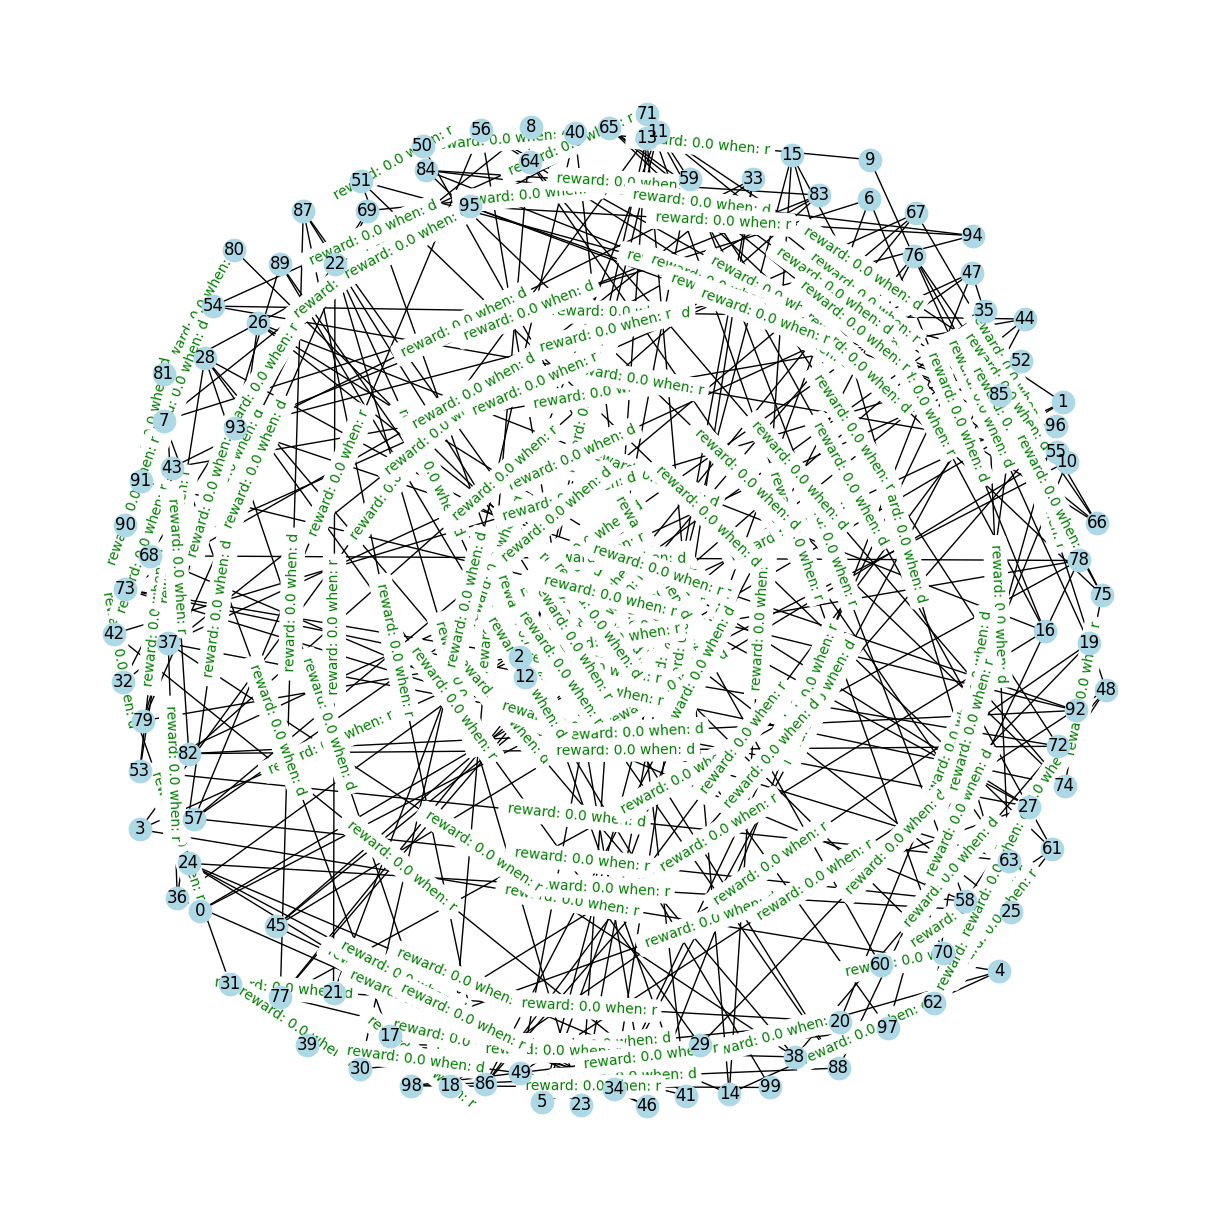

In [19]:
for q_table in q_tables_dict.items():
  print(str(q_table[0]) + ":")
  draw_weighted_graph(q_table[1], init_maze)
  break

#### Running the code for different amounts of alpha and gamma:

In [17]:
def alpha(a):
  q_tables_dict, flags_in_order, reward_list = multiple_flag_q_learning(init_maze, flags, a, d_factor, exp_factor, epoch, print_results=False)
  reward =sum(reward_list)
  return reward

In [18]:
def gamma(g):
  q_tables_dict, flags_in_order, reward_list = multiple_flag_q_learning(init_maze, flags, learning_rate, g, exp_factor, epoch, print_results=False)
  reward =sum(reward_list)
  return reward

In [19]:
alpha_list = [0.05, 0.1, 0.5,1]
alpha_reward = []
for i in alpha_list:
  alpha_reward.append(alpha(i))

for i in range(len(alpha_list)):
  print("alpha = ", alpha_list[i]," reward = ", alpha_reward[i])

alpha =  0.05  reward =  -248.94000000000068
alpha =  0.1  reward =  -288.6199999999986
alpha =  0.5  reward =  -245.6599999999996
alpha =  1  reward =  -474.94000000000284


pha =  0.05  reward =  -367.55\
alpha =  0.1  reward =  -455.89\
alpha =  0.5  reward =  -477.89\
alpha =  1  reward =  -733.50\
**Alpha** is a learning rate that controls the amount of update to the Q-values in Q-Learning. It determines the trade-off between exploration and exploitation. A high alpha means that the agent updates its Q-values more quickly, which leads to more exploration, while a low alpha means the agent updates its Q-values more slowly, leading to more exploitation of what it has learned so far.

In the rewards given, we can see that as the value of alpha increases, the reward value decreases. This suggests that as the learning rate increases, the agent is making more updates to its Q-values, exploring more and hence, is not making the most optimal decisions. The result is a lower reward value compared to when the learning rate is smaller, indicating a higher level of exploitation of the learned Q-values.



In [20]:
gamma_list = [0.1, 0.25, 0.5, 1]
gamma_reward = []
for i in gamma_list:
  gamma_reward.append(gamma(i))

for i in range(len(gamma_list)):
  print("gamma = ", gamma_list[i], " reward = ", gamma_reward[i])

gamma =  0.1  reward =  -247.94000000000074
gamma =  0.25  reward =  -142.29999999999993
gamma =  0.5  reward =  -243.94000000000034
gamma =  1  reward =  -305.3800000000013


gamma =  0.1  reward =  -398.64\
gamma =  0.25  reward =  -482.40\
gamma =  0.5  reward =  -519.05\
gamma =  1  reward =  -552.35\
In Q-Learning, gamma (also known as the discount factor) is a hyperparameter that determines the importance of future rewards in comparison to immediate rewards. The value of gamma can range between 0 and 1.

In this case, as the value of gamma increases, the rewards decrease. This means that when the value of gamma is close to 1, the agent places more importance on future rewards and less importance on immediate rewards. Conversely, when the value of gamma is close to 0, the agent places more importance on immediate rewards and less importance on future rewards.

For example, when gamma is 0.1, the agent receives a reward of -398.65. This indicates that the agent is taking into account both the immediate rewards and future rewards, but placing more importance on the immediate rewards. As the value of gamma increases to 1, the reward decreases to -552.35, indicating that the agent is placing more importance on the future rewards and less importance on the immediate rewards.





#### Checking a new environment:

In [21]:
#new env
# Define the maze 
init_maze = np.array([
    [ 1,  0,  1,  0, 1],
    [ 1,  0,  1,  1, 1],
    [ 1,  0,  1,  0, 0],
    [ 1,  1,  1,  1, 0],
    [ 1,  1,  1,  1, 1]
])

flags = [(1, 2), (2, 3), (4, 1)]


learning_rate = 0.05   
d_factor = 0.1
exp_factor = 1   
epoch = 100
q_tables_dict, flags_in_order, reward_list = multiple_flag_q_learning(init_maze, flags, learning_rate, d_factor, exp_factor, epoch, print_results=True)

policy_dict = get_optimal_policies(q_tables_dict,flags_in_order)
print_all_policies(policy_dict, flags_in_order, reward_list)

flag: (2, 3)
Q able: [[-0.025  0.     0.     0.     0.    -0.025  0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.    -0.001 -0.001  0.     0.
   0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  -0.001 -0.025  0.     0.     0.     0.     0.     0.     0.05   0.
   0.     0.     0.     0.     0.   ]
 [ 0.    -0.001  0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.   ]
 [-0.001  0.     0.     0.     0.    -0.001 -0.049  0.     0.     0.
   0.    -0.001  0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.   ]]
flag: (1, 2)
Q table: [[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.    -0.025  0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.002
   0